In [6]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
import pickle

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from warnings import filterwarnings

# Task 4 - Classification 

## Load settings

In [12]:
grid = None
k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA
taskname = "task4"
#filedir = "/home/fredrik/Documents/Learning_systems/Labs/Project/"
filedir = "C:/Users/fredr/Documents/github-projects/Learning_systems/Labs/Project/"

scoring='accuracy' # Scoring method for GridsearchCV
score_function = f_classif # Score function for Feature selection
verbose=10

np.random.seed(seed) # Define the random seed

In [8]:
# Define models that should be trained
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[LinearSVC()],
        'clf__penalty':['l1','l2'],
        'clf__C': [0.1,0.5,1,1.5,2.0],
        'clf__dual':[True,False]
    },{
        'clf':[SVC()],
        'clf__C':[1,0.5,1,5.2],
        'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__degree':[1,2,3],
        'clf__gamma':['scale', 'auto'],
        'clf__max_iter':[1000,5000,10000],
    },{
        'clf':[RandomForestClassifier()],
        'clf__n_estimators':[100,150,200],
    },{
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':[5,3,6,8],
        'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'clf__leaf_size':[30,15,20,40]
    },{
        'clf':[MLPClassifier()],
        'clf__hidden_layer_sizes':[(100,20)],
        'clf__activation':['relu', 'tanh', 'logistic'],
        'clf__solver':['adam', 'lbfgs'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,400],
        'clf__early_stopping':[True, False]
    }
]

## Load dataset

In [9]:
filename = "datasets/thyroidTrain.mat"

mat = loadmat(filename)
input_train = mat['trainThyroidInput']

target_train = mat['trainThyroidOutput']
input_test = mat['testThyroidInput']

## Data info

In [10]:
get_data_info(input_train, target_train)

Length of 5000
X.shape: (5000, 21) y.shape: (5000, 3)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False


## Preprocess
Normalize the dataset

In [34]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

One hot --> single value output
Length of input: 5000


## Feature distribution

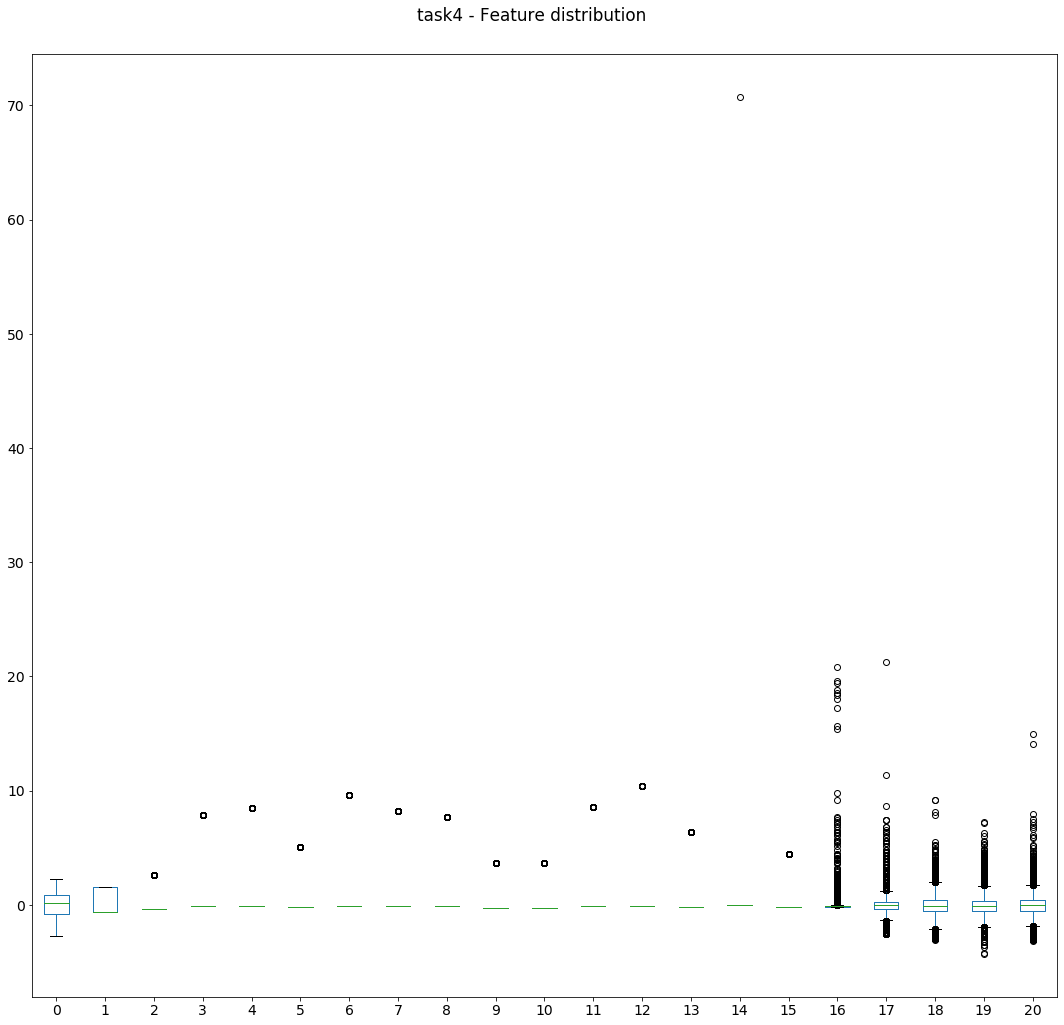

In [35]:
plot_feature_distribution(input_train, filedir=filedir, taskname=taskname)

## Feature reduction
Reduce dimensionality by PCA transform

In [36]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (5000, 21)
transformed shape: (5000, 19)
Explained variance: [0.11644462 0.07693855 0.06624585 0.05484826 0.05400037 0.05290859
 0.04951334 0.04840626 0.04679861 0.04582658 0.04538423 0.04431255
 0.04244733 0.04194532 0.04107869 0.04019269 0.03850317 0.03597675
 0.03242482]


## Feature extraction

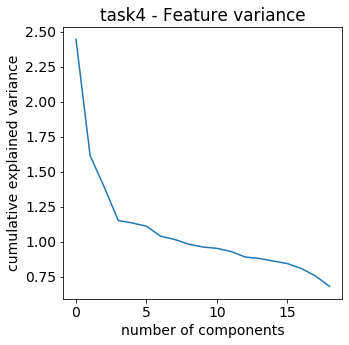

In [37]:
plot_feature_variance(pca_input, filedir=filedir, taskname=taskname)

## Feature selection
Extract top features above depending on PCA

[ 0  1  2  3  4  5  6  7  8  9 11 12 13 15 16 17 18 19 20]
Shape of input: (5000, 21)


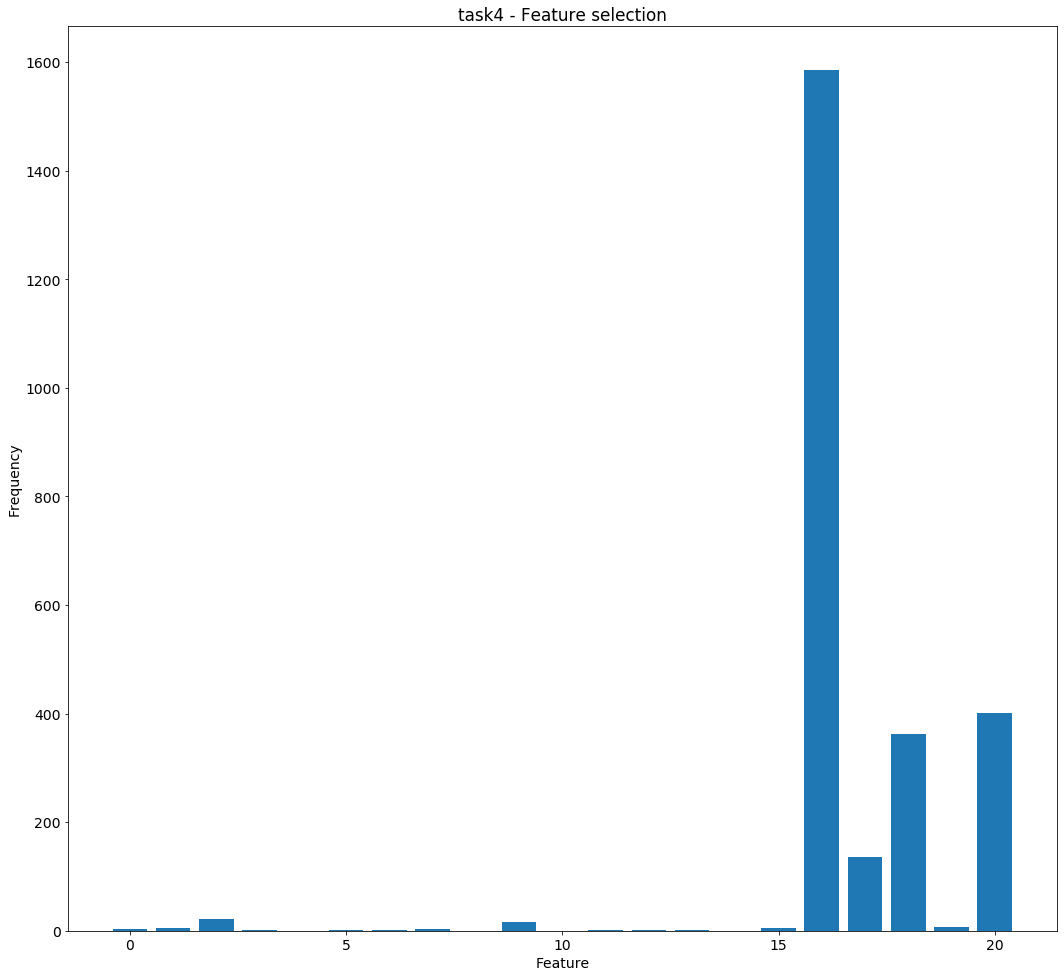

In [38]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, filedir=filedir, taskname=taskname,feature_tot=feature_tot)

## Feature Relationship

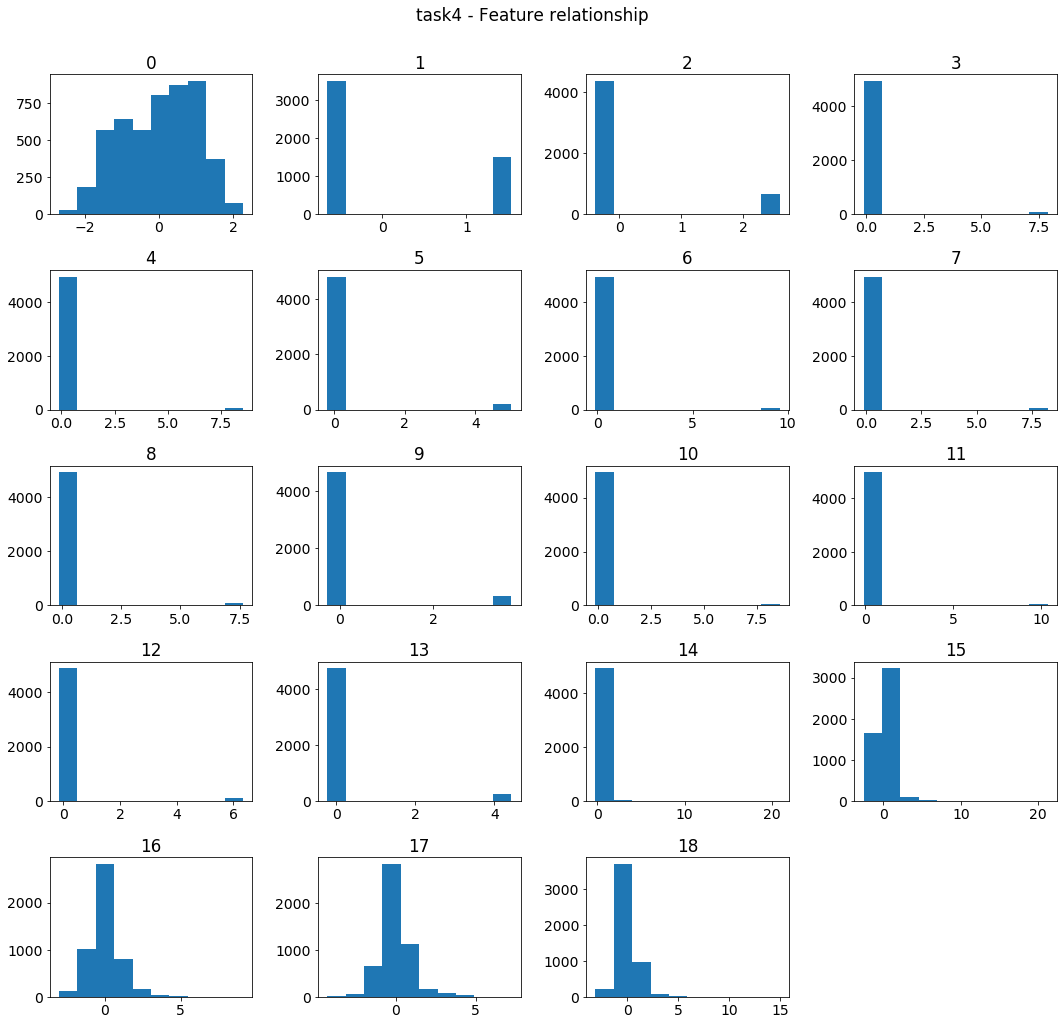

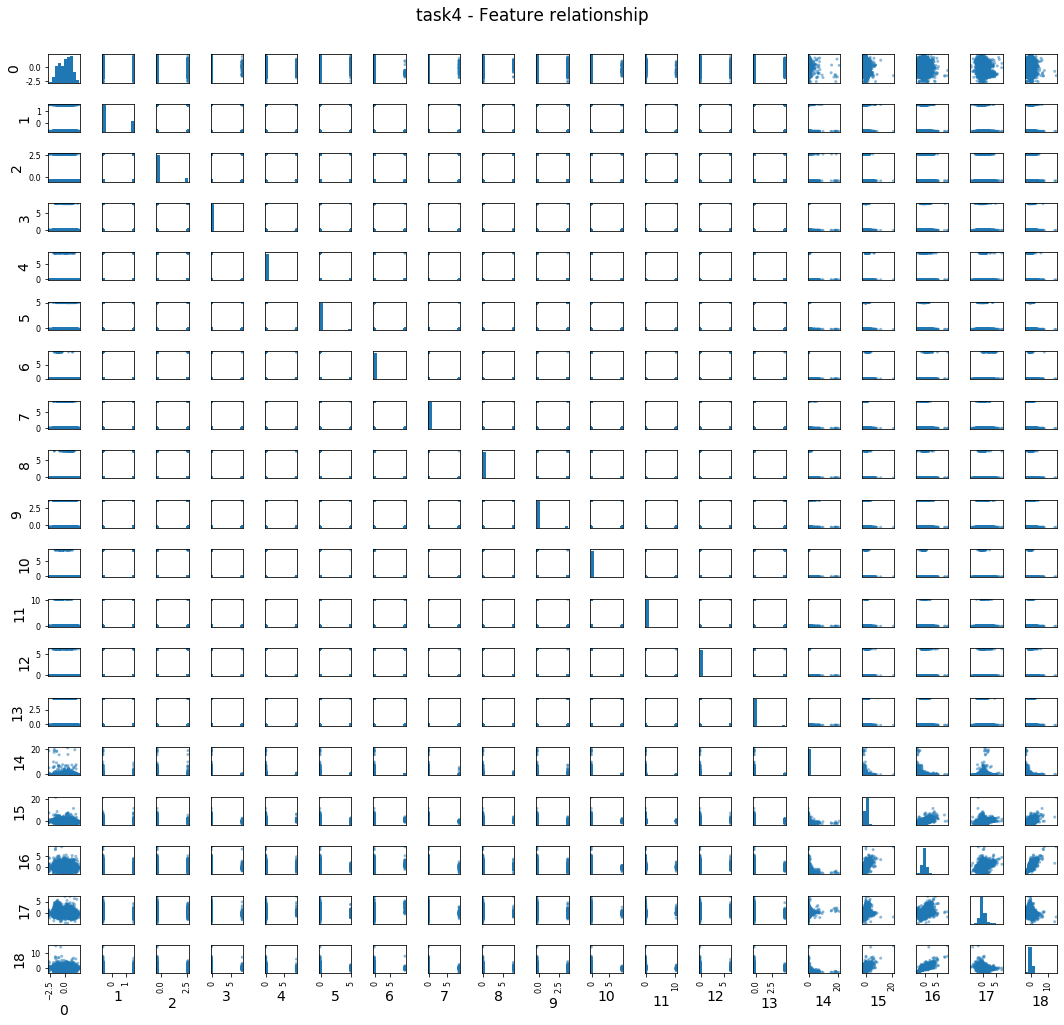

In [39]:
plot_feature_relationship(input_train_fs, filedir, taskname)

## Hyperparameter tuning

In [40]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 447 candidates, totalling 4470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 75.7min
[Parallel(n_jobs=-1)]: Done 4470 out of 4470 | elapsed: 114.0min finished


## Save model

In [41]:
save_model(grid, filedir=filedir, taskname=taskname)

Save model into: /home/fredrik/Documents/Learning_systems/Labs/Project/Models/task4.joblib


## Load model

In [13]:
if not grid: 
    grid = load_model(filedir=filedir, taskname=taskname)

Loading model:  C:/Users/fredr/Documents/github-projects/Learning_systems/Labs/Project/Models/task4.joblib


ValueError: Buffer dtype mismatch, expected 'SIZE_t' but got 'long long'

## Get Model info

In [5]:
get_model_info(grid)

AttributeError: 'NoneType' object has no attribute 'cv_results_'

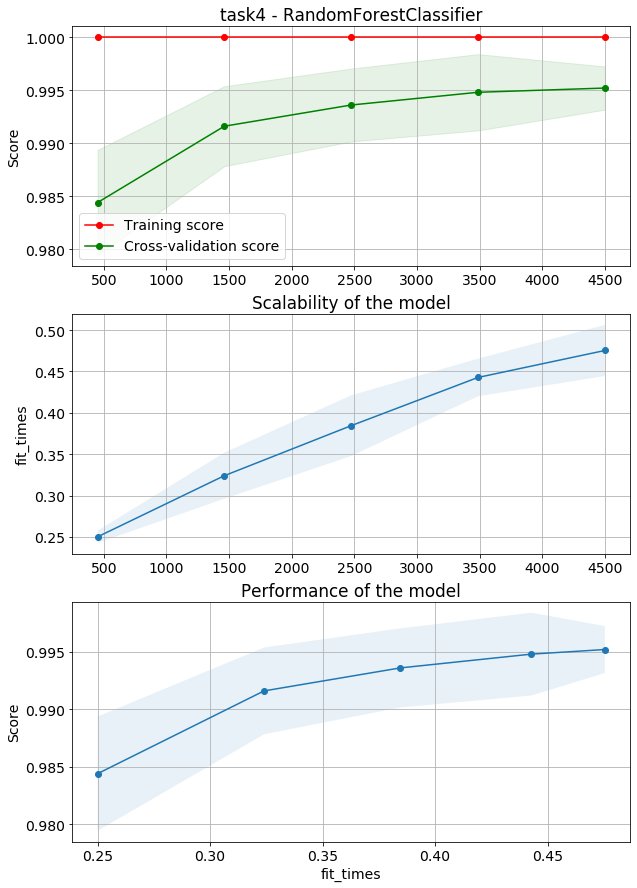

In [44]:
validate_curve(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname,scoring=scoring, k=k)

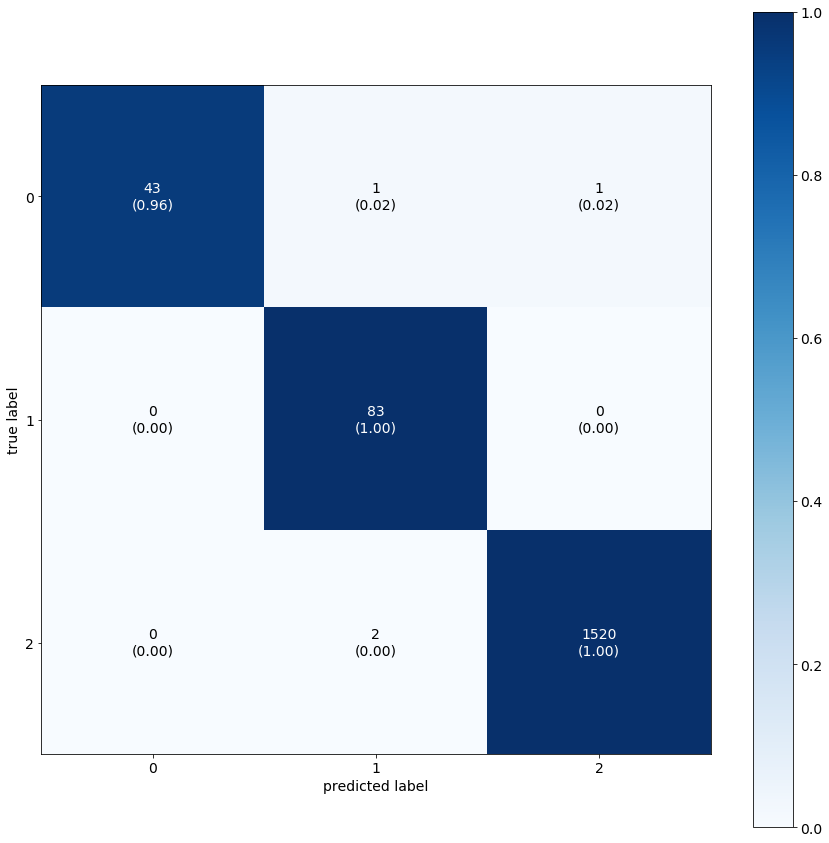

In [45]:
display_confusion_matrix(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname)

# Predict testset

In [46]:
_,predict = predict_model(grid, input_train_fs, target_train, input_test_fs)
save_prediction(predict, filedir, taskname)
print(predict)

[2 2 2 2 2 2 1 0 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 1 2 2 2 2 2 1 0 2 2 2 2 2 1 2 0 0 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 1 2 2 1 2 1 2 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 